In [1]:
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime

# bokeh libraries
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, output_file
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, Legend, HoverTool
from bokeh.plotting import figure, show

output_notebook()
#output_file("plot.html")


Loading BokehJS ...

In [2]:
#set rendering to notebook
output_notebook()

#uncomment the following two lines if you get an SSL error when downloading the data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

path = "https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_260.zip"
df = pd.read_csv(path,compression='zip', skiprows=51, low_memory=False)
df.head()

Loading BokehJS ...

,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19010101,,,,,,,,,...,,,,,66,,,,,
1,260,19010102,,,,,,,,,...,,,,,86,,,,,
2,260,19010103,,,,,,,,,...,,,,,89,,,,,
3,260,19010104,,,,,,,,,...,,,,,79,,,,,
4,260,19010105,,,,,,,,,...,,,,,65,,,,,


In [3]:
def preprocess(df):
    """
    Preprocess 'De Bilt etmaalgegevens' for analysis.
    Renames KNMI columns, selects relevant variables,
    converts datatypes, and standardizes units.
    """

    df = (
        #Renames cryptic KNMI column names
        df.rename(
            columns={
                "YYYYMMDD": "date",
                "   TG": "temperature",
            },
            errors="raise",
        )
        #Keep only relevant variables
        .loc[:, ["date", "temperature"]]
        #Convert to appropriate datatypes and standardize units
        .assign(
            date=lambda x: pd.to_datetime(x["date"], format="%Y%m%d", errors="coerce"),
            temperature=lambda x: pd.to_numeric(x["temperature"], errors="coerce") / 10,
        )
        # Makes the DataFrame a time series: Enables easy plotting, resampling, rolling averages, etc.
        .set_index("date")
    )

    return df


In [4]:
df = preprocess(df)

In [5]:
df.head()

,temperature
date,
1901-01-01,-5.0
1901-01-02,-2.2
1901-01-03,-2.9
1901-01-04,-6.4
1901-01-05,-5.9


In [6]:
print(plt.style.available)
plt.style.use('dark_background')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


When you set the datetimestamp as index you can slice date series of interest

In [7]:
subset = df['2000':'2024']
subset

,temperature
date,
2000-01-01,6.1
2000-01-02,7.3
2000-01-03,8.4
2000-01-04,6.4
2000-01-05,4.4
...,...
2024-12-27,2.5
2024-12-28,1.0
2024-12-29,4.0


In [8]:
subset = df['2000-01-01':'2024-01-01']
subset

,temperature
date,
2000-01-01,6.1
2000-01-02,7.3
2000-01-03,8.4
2000-01-04,6.4
2000-01-05,4.4
...,...
2023-12-28,10.9
2023-12-29,9.3
2023-12-30,8.1


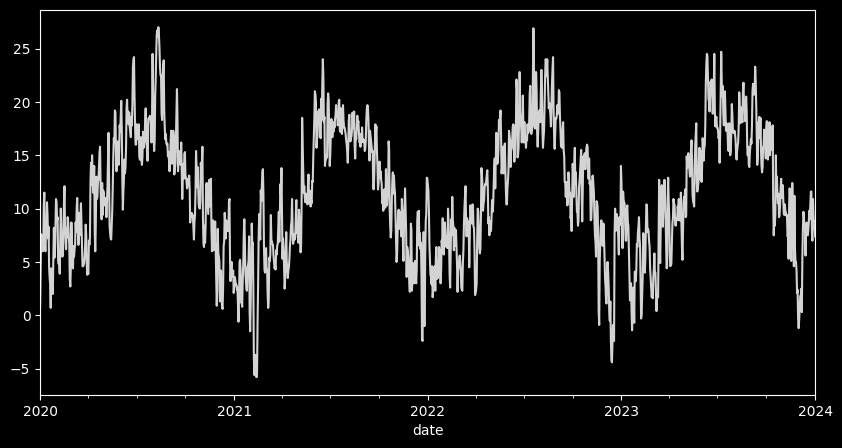

In [9]:
sub = df['2020-01-01':'2024-01-01']
sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
plt.savefig('weather_raw.png')

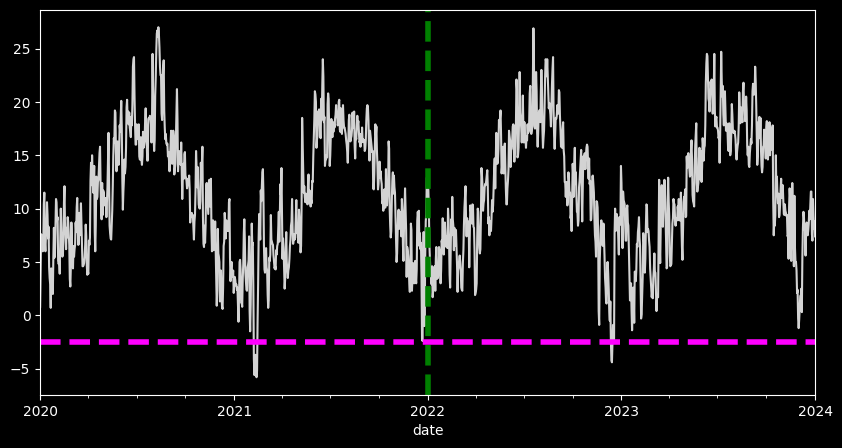

In [10]:
ax = sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
# Add a vertical line
ax.axvline('2022-01-01', color='green', linestyle='--', linewidth=4)
# Add a horizontal line
ax.axhline(-2.5, color='magenta', linestyle='--', linewidth=4)
plt.savefig('weather_lines.png')

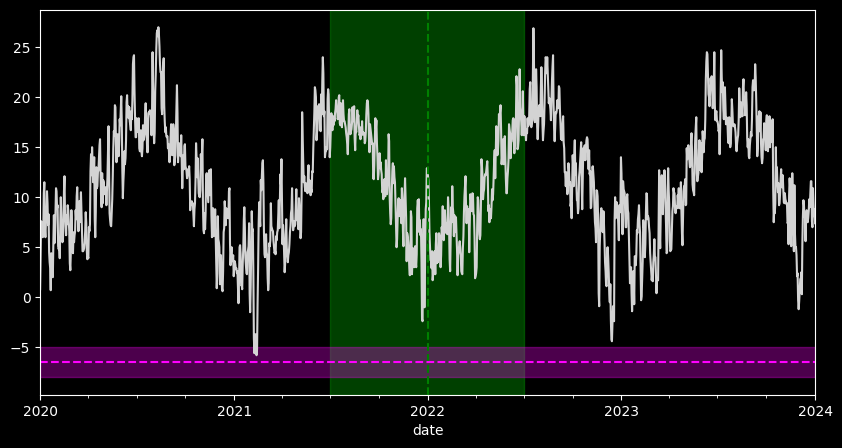

In [11]:
ax = sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
# Add a vertical line
ax.axvline('2022-01-01', color='green', linestyle='--')
# Add a horizontal line
ax.axhline(-6.5, color='magenta', linestyle='--')

# Add a vertical green shaded region
ax.axvspan('2021-07-01', '2022-07-01', color='green', alpha=0.5)

# Add a horizontal magenta shaded region
ax.axhspan(-5, -8, color='magenta', alpha=0.3)

plt.savefig('weather_span.png')

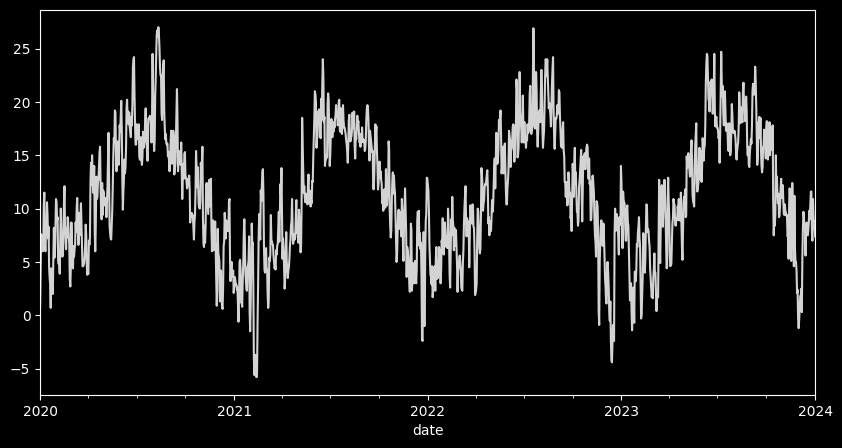

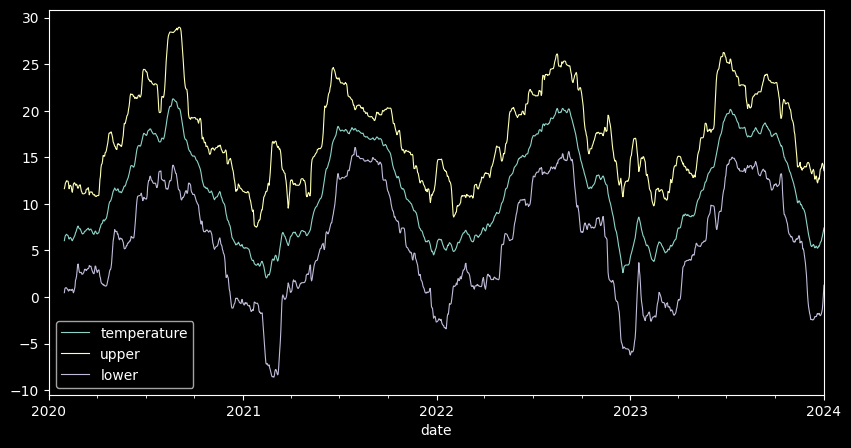

In [12]:
ax = sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
# Compute n days rolling mean
rmw = sub.rolling(window=30).mean()

# Compute n days rolling stdev
rsw = sub.rolling(window=30).std()

# Add the upper bound column rmw DataFrame
rmw['upper'] = rmw['temperature'] + (rsw['temperature'] * 2)

# Add the lower bound column rmw DataFrame
rmw['lower'] = rmw['temperature'] - (rsw['temperature'] * 2)

# Plot the content of the ma DataFrame
ax = rmw[['temperature','upper', 'lower']].plot(linewidth=0.8, figsize=(10, 5))

plt.savefig('weather_rolling.png')

In [13]:
#uncomment the following two lines if you get an error in the next cell
#import bokeh
#bokeh.sampledata.download()


In [14]:
from bokeh.models import DatetimeTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.glucose import data

#reduce data size
data = data.loc['2010-10-06':'2010-10-13'].reset_index()

p = figure(x_axis_type="datetime", background_fill_color='black')
p.line("datetime", "glucose", source=data, color="cyan", legend_label="glucose")

p.title.text = "Glucose Range"
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Value'
p.legend.level = "overlay"
p.legend.location = "top_left"

# Formatting x-axis tick labels
p.xaxis.formatter = DatetimeTickFormatter(days="%d %b %Y")


show(p)